# ATMS 523 - Module 2
## Introduction to `dask`

We all want faster computation, right?  Most computers today are multi-threaded machines that can perform computations in parallel.  Even a $1000 laptop can have 6 or 8 CPU cores that can be used to speed up processing.  It's easy to take advantage of the CPUs in these computers to accelerate computations by many times.  In addition, modern servers can have 32-64 CPU cores or more per machine, and high-performance computing clusters can allow scaling up to hundreds and thousands of processors.  In python, one package that can handle scaling computational tasks across different types of computational platorms is `dask`.  

`dask` was developed to enable a simple interface to a library that can allow for distributed memory calculations across an arbitrary number of CPUs on one or many machines (through the `dask-distributed` package).  This allows for doing calculations on large datasets that use common `python` tools such as `numpy`, `pandas`, and `xarray`, with only minor changes in syntax.  Large datasets that are larger that are bigger than the random access memory (RAM) are called "out of memory calculations".  `dask` has the ability to automatically or manually "chunk" large arrays into pieces that can fit into the RAM of an individual machine or machine(s), enabling an easier pathway to solving big data problems.

In this exercise we will demonstrate the use of `dask` on a local machine (a relatively modest MacBook Pro) to see the benefits of using `dask` in your workflows.



---

### installing `dask`

First, `dask` can be installed with

`conda install dask`

Make sure you are installing in the conda environment you expect.



### Using `dask` on your local machine
in your `python` environment.  Once `dask` is installed, you can import it into your `python` session with the following cell:

In [1]:
from dask.distributed import Client, progress
import dask
# add if you have permissions problems on your temporary directory
dask.config.set(temporary_directory='/tmp/snesbitt-dask')

Now, we will create a `dask` local client object to start the process

In [2]:
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50714,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50741,Total threads: 2
Dashboard: http://127.0.0.1:50743/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50718,


Now, if you expand the arrow on the output of the Client object, you can see:

![Dask Cluster](dask_cluster.png)

The Client tells us that there is a dashboard running at a web address that you can click on, and it also tells us the resources that we have available: 8 threads, 4 workers, and 16 gigabytes of RAM.  These are the characteristics of this laptop.  However, `dask` will allow us to more fully use the capabilities of this machine.



### Getting started with `dask`

Once we have a `dask` Client, we can use it to submit computations.  Let's get started with something simple.

#### `dask` demo

Let's start with a simple calculation.  Let's say we need to compute the negative of the square root of an array.  We could easily do this with `numpy` for a small array:

In [3]:
import numpy as np

Let's create an array with $10^9$ elements.

In [ ]:
images = np.zeros([1000,1000,1000])
images

Should work fine on most machines.  Now, let's try making an array with $10^{16}$ elements!

In [ ]:
images = np.zeros([1000,1000,1000,1000,1000])
images

You can see that this did not go so well.  My machine has 16 GB of physical RAM, plus some virtual swap memory on the hard drive (Max 1 TB), but this is more than my computer can provide.  What can we do at this point?  Well, in the old days, we would split this task up into smaller tasks, and then recombine, but this takes time and sometimes a lot of effort. 

Is there a way to do this in a way where we can split this computation up such that we can work on datasets that are larger than the memory capabilities of a machine?  Yes!

Let's swap out `numpy` for calls in the package `dask`, which streamlines and accellerates many large data processing tasks.

In [6]:
import dask.array as da

images = da.zeros([1000,1000,1000,1000,1000])
images

,Array,Chunk
Bytes,7.11 PiB,74.51 MiB
Shape,"(1000, 1000, 1000, 1000, 1000)","(25, 25, 25, 25, 25)"
Count,1 Graph Layer,102400000 Chunks
Type,float64,numpy.ndarray


Now, you can see that `dask` has split this problem up into chunks of `numpy` arrays, each of which can be split into available memory, and even on to available CPUs on the machine.  This both solves the memory problem and can enable parallel computation on large arrays, which should save us consierable time writing code to break this problem down into smaller ones.

Let's try a quick solution to a problem of processing a large dataset.

Install `gcsfs` to perform this calculation (i.e., `conda install gcsfs` in your class conda environemnt), where the data resides on the in a Google Cloud S3 bucket (one way public datasets are shared).  Also, make sure that the `dask distributed` client is running above!

Also make sure `ipywidgets` is installed, so you have a fancy progress bar!

This data is a table in csv format, so we will just use `pandas` to read it.

In [6]:
import dask
import dask.dataframe as dd
# browse here: https://console.cloud.google.com/storage/browser/anaconda-public-data/nyc-taxi/csv;tab=objects?prefix=&forceOnObjectsSortingFiltering=false

df = dd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow_tripdata_2015-02.csv',
                 storage_options={'token': 'anon'}, dtype={'extra': 'float64',
                'tolls_amount': 'float64'},
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])[['tip_amount','fare_amount']]


In [7]:
df

,tip_amount,fare_amount
npartitions=30,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


In [5]:
#df = df.persist()
#progress(df, notebook=False)

Now, let's compute how many rows are in the dask dataframe, and in the following cell, how many passengers took taxis in 2015 in New York City.  Note that this could take some time, depending on your internet connection.  You can watch the progress of the computation if you go to the "Dashboard Address" that is listed when you started your `dask` cluster above.

How many passengers rode NYC taxis in 2015?

In [19]:
%time df.passenger_count.sum().compute()

CPU times: user 3.24 s, sys: 727 ms, total: 3.97 s
Wall time: 26.5 s


245566747

In [8]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount

In [11]:
df2['tip_amount'].max().compute()

1603.05

In [21]:
# Group df.tpep_pickup_datetime by dayofweek and hour
dayofweek = df2.groupby(df2.tpep_pickup_datetime.dt.dayofweek).tip_fraction.mean() 
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()

dayofweek, hour = dask.persist(dayofweek, hour)
progress(dayofweek, hour, notebook=False)

<AxesSubplot:title={'center':'Tip Fraction by Day'}, xlabel='tpep_pickup_datetime'>

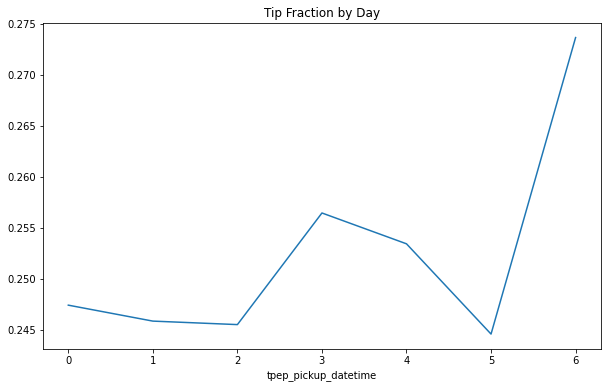

In [24]:
dayofweek.compute().plot(figsize=(10, 6), title='Tip Fraction by Day')

When this is done, you can see that with minimal coding, you can access a large cloud dataset, process it in parallel, and with minimal coding!  And you discovered that people are either really generous in NYC late at night, or they have trouble counting their money!

When you are done with your dask cluster, you can close it to recover the resources it used.

In [25]:
client.close()